In [54]:
import pickle
import random
import sys
import io
import os
import re
import keras
import urllib
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing.text import one_hot
from skimage.color import rgb2grey
from sklearn.cluster import KMeans
from sklearn import preprocessing
from keras.datasets import cifar10
import warnings
warnings.filterwarnings("ignore")

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict= pickle.load(fo, encoding ='bytes')
    return dict

# def cifar_10_reshape(batch):
#     output=np.reshape(len(batch),3,32,32).transpose(0,2,3,1)
#     return output

In [3]:
def load_cifar10_data(data):
    train_data = None
    train_labels = []

    for i in range(1, 6):
        batch = unpickle(data + "/data_batch_{}".format(i))
        print(batch.keys())
        if i == 1:
            train_data = batch[b'data']
        else:
            train_data = np.vstack((train_data, batch[b'data']))
        train_labels += batch[b'labels']

    test_batch = unpickle(data + "/test_batch")
    test_data = test_batch[b'data']
    test_labels = test_batch[b'labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32)).transpose([0, 2, 3, 1])
#     train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)

    test_data = test_data.reshape((len(test_data), 3, 32, 32)).transpose([0, 2, 3, 1])
#     test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


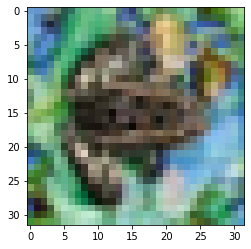

In [4]:
data_dir = '/Users/phuongqn/Desktop/INF552/Homework/Homework 7 Data/cifar-10-batches-py'

train_data, train_labels, test_data, test_labels = load_cifar10_data(data_dir)

print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

plt.imshow(train_data[200])
plt.show()


In [5]:
bird_train = train_data[train_labels == 2]
bird_test = test_data[test_labels == 2]
birds=np.concatenate([bird_train, bird_test])

In [6]:
birds.shape

(6000, 32, 32, 3)

First 10 Images in the dataset:


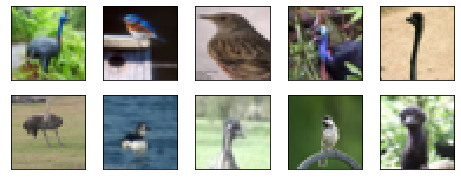

In [7]:
print('First 10 Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(bird_train[i])
plt.show()

In [8]:
total_px=birds.shape[0]*birds.shape[1]*birds.shape[2]
pct=0.9
rand_len=int(total_px*pct)
img_idx = np.random.randint(6000, size = (rand_len, ))
row_idx = np.random.randint(32, size = (rand_len, ))
col_idx = np.random.randint(32, size = (rand_len, ))

In [9]:
rand_px = birds[img_idx, row_idx, col_idx, :]

In [10]:
rand_px.shape

(5529600, 3)

In [11]:
k=4
kmodel=KMeans(n_clusters=k, random_state= 158).fit(rand_px)

In [12]:
main_colors=kmodel.cluster_centers_
print('RGB', k, 'main colors:')
print(main_colors)

RGB 4 main colors:
[[ 49.23483453  50.17706302  38.65317161]
 [206.6507071  211.97462326 211.76445116]
 [109.20479589 108.85760204  82.99328908]
 [156.53157139 155.85529727 135.89444358]]


In [13]:
pred_birds=kmodel.predict(birds.reshape(-1, birds.shape[-1]))
four_color_birds=[]
px_colors=[]
for i in range(len(pred_birds)):
    clusterLabel = pred_birds[i]
    four_color_birds.append(main_colors[clusterLabel])
    oneHotEncoding = np.zeros(k)
    oneHotEncoding[clusterLabel] = 1
    px_colors.append(oneHotEncoding)
    i += 1
four_color_birds = np.array(four_color_birds)
four_color_birds = np.reshape(four_color_birds, (6000,32,32,3)) 

px_colors = np.array(px_colors)
px_colors = np.reshape(px_colors, (6000, 32*32*k))

In [14]:
pred_birds2=kmodel.predict(rand_px)

In [15]:
pred_birds2.shape

(5529600,)

In [16]:
four_color_birds2 = kmodel.cluster_centers_[pred_birds2]

In [17]:
four_color_birds2

array([[206.6507071 , 211.97462326, 211.76445116],
       [ 49.23483453,  50.17706302,  38.65317161],
       [156.53157139, 155.85529727, 135.89444358],
       ...,
       [206.6507071 , 211.97462326, 211.76445116],
       [156.53157139, 155.85529727, 135.89444358],
       [156.53157139, 155.85529727, 135.89444358]])

In [18]:
four_color_birds2 = np.uint8(four_color_birds2.reshape((5400, 32, 32, 3)))

Output Images in the dataset:


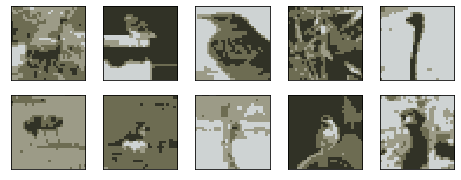

In [20]:
print('Output Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(four_color_birds[i].astype(np.uint8))
plt.show()

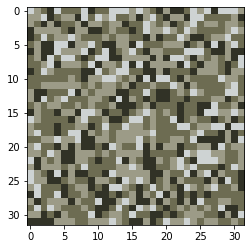

In [21]:
plt.imshow(four_color_birds2[3].astype(np.uint8))
plt.show()

In [22]:
px_colors.shape

(6000, 4096)

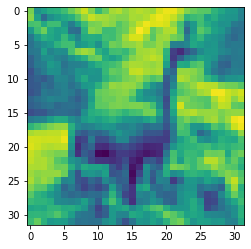

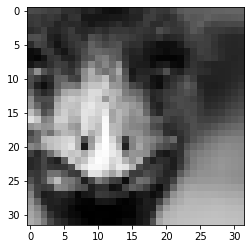

In [34]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
gray_train = rgb2gray(bird_train)
gray_test = rgb2gray(bird_test)
plt.imshow(gray_train[0])
plt.show()
plt.imshow(gray_test[1], cmap='gray')
plt.show()


In [70]:
CNN=Sequential()
CNN.add(Conv2D(64, kernel_size=(5, 5), strides=(1,1), input_shape=(32, 32, 1), padding='same',activation='relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2),strides=(1,1), padding='same'))
CNN.add(Dropout(0.25))
CNN.add(Conv2D(64, kernel_size=(5, 5), strides=(1,1), padding='same',activation='relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2),strides=(1,1),padding='same'))
CNN.add(Dropout(0.22))
# CNN.add(Flatten())
CNN.add(Dense(32, activation='softmax'))
CNN.add(Dense(4, activation='softmax'))
CNN.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
dense_28 (Dense)             (None, 32, 32, 32)      

In [71]:
adam = keras.optimizers.Adam(lr=0.5)
CNN.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
filepath="/Users/phuongqn/Desktop/INF552/HW-Phuong/LSTMweights/weights-improvement-bird-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
gray_train=gray_train.reshape(5000, 32, 32,1)
gray_test=gray_test.reshape(1000, 32, 32,1)

In [73]:
from sklearn.model_selection import train_test_split
X_train = gray_train[:5000, :, :, :]
labels = px_colors[:5000, :]
labels= labels.reshape(5000, 32,32,4)
# Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [74]:
history = CNN.fit(gray_train, labels, verbose=1, validation_split=0.1, epochs=30, batch_size = 32, callbacks= callbacks_list)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 27s 6ms/step - loss: 1.3708 - accuracy: 0.3147 - val_loss: 1.4269 - val_accuracy: 0.3058

Epoch 00001: loss improved from inf to 1.37077, saving model to /Users/phuongqn/Desktop/INF552/HW-Phuong/LSTMweights/weights-improvement-bird-01-1.3708-bigger.hdf5
Epoch 2/30
4500/4500 [==============================] - 29s 6ms/step - loss: 1.3664 - accuracy: 0.3205 - val_loss: 1.4032 - val_accuracy: 0.3058

Epoch 00002: loss improved from 1.37077 to 1.36642, saving model to /Users/phuongqn/Desktop/INF552/HW-Phuong/LSTMweights/weights-improvement-bird-02-1.3664-bigger.hdf5
Epoch 3/30
4500/4500 [==============================] - 29s 6ms/step - loss: 1.3642 - accuracy: 0.3228 - val_loss: 1.3802 - val_accuracy: 0.3464

Epoch 00003: loss improved from 1.36642 to 1.36420, saving model to /Users/phuongqn/Desktop/INF552/HW-Phuong/LSTMweights/weights-improvement-bird-03-1.3642-bigger.hdf5
Epoch 4/30
4500

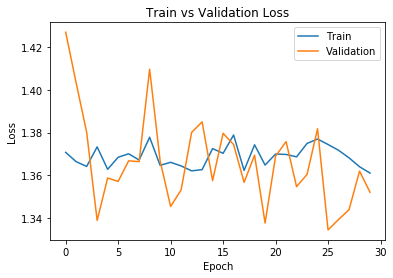

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [133]:
file='/Users/phuongqn/Desktop/INF552/HW-Phuong/LSTMweights/weights-improvement-bird-30-1.3611-bigger.hdf5'
CNN.load_weights(file)
CNN.compile(loss='categorical_crossentropy', optimizer='adam')
preds=CNN.predict(gray_test)
preds.shape

(1000, 32, 32, 4)

In [134]:
ytest = px_colors[5000:, :]
ytest=ytest.reshape(1000, 32,32,4)

In [135]:
scores=CNN.evaluate(gray_test, ytest, verbose=1)
print('Test loss:', scores)
# print('Test accuracy:', scores[1])

1000/1000 [==============================] - 1s 1ms/step
Test loss: 1.37489497756958


In [137]:
preds = np.argmax(preds, axis=3)
preds= kmodel.cluster_centers_[preds]

In [138]:
preds.shape

(1000, 32, 32, 3)

In [136]:
ytest = np.argmax(ytest, axis=3)
ytest= kmodel.cluster_centers_[ytest]
ytest.shape

(1000, 32, 32, 3)

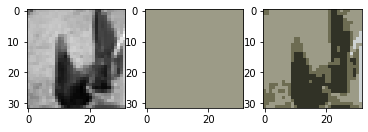

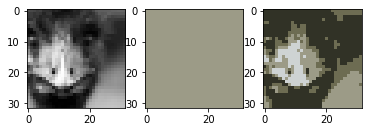

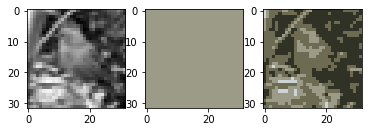

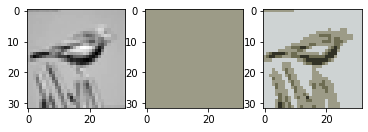

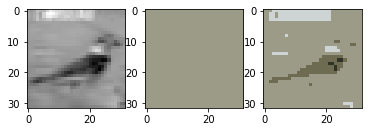

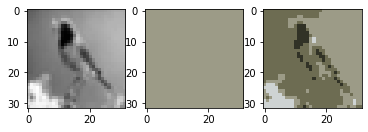

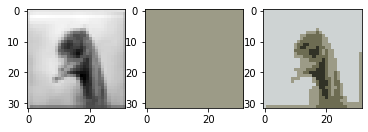

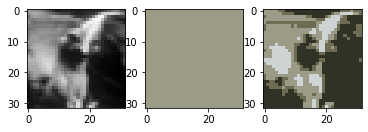

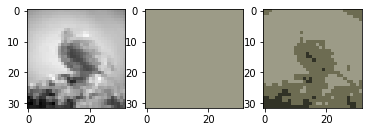

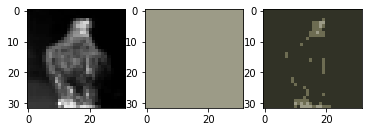

In [140]:
for i in range(10):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(np.uint8(gray_test[i].reshape((32, 32))), cmap = 'gray')
    axarr[1].imshow(np.uint8(preds[i].reshape((32, 32, 3))))
    axarr[2].imshow(np.uint8(ytest[i]))